# Getting Started with CCC Analysis

This notebook contains software for receptor:ligand analysis of single-cell RNA sequencing of opossum uteri from time points across the reproductive cycle of *Monodelphis domestica*.
    
The general analytical approach is to:

- Load processed and clustered single-cell data from the opossum uterus
- Subset to stages and cell types of interest (e.g. all epithelial-mesenchymal interactions from late gestation)
- Use OmniPath to query databases of receptor:ligand interactions, utilizing workflows from https://workflows.omnipathdb.org/
- Since we do not have spatial data, we may want to restrict the database to remove certain physical cell:cell interactions and focus on diffusible signals
- Compare receptor:ligand interacitons across stages

## Software Import

These commands load the required packages into Python.

We also load custom functions from the [`chinpy`](https://gitlab.com/dnjst/chinpy) package. The package is partially a reimplementation of `Connectome` scoring in python and partially intended to be an extension and improvement now that development on that has stalled.

In [18]:
!pip install -i https://test.pypi.org/simple/ chinpy --upgrade

# custom squidpy fork
# pip install git+https://github.com/dnjst/squidpy.git --upgrade

Looking in indexes: https://test.pypi.org/simple/


In [19]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sp
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import omnipath as op
import scipy
import os
# matplotlib settings for Jupyter notebooks only
%matplotlib inline

# load custom package
import chinpy

Make pretty (huge) figures.

In [2]:
#sc.set_figure_params(scanpy=True, dpi=300, dpi_save=300, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='svg', facecolor=None, transparent=True, ipython_format='png2x')

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

# pandas show more rows
#pd.set_option('display.min_rows', 30)
#pd.set_option('display.max_rows', 40)

There is currently no website documentation, but the program itself has documentation through the `help()` command:

In [3]:
help(chinpy.ccc.create_connectome)

Help on function create_connectome in module chinpy.ccc.create_connectome:

create_connectome(adata: anndata._core.anndata.AnnData, cluster_key: str, clusters: Union[Sequence[str], Tuple[Sequence[str], Sequence[str]], Sequence[Tuple[str, str]], NoneType] = None, complex_policy: Union[ForwardRef('min'), ForwardRef('all')] = 'min', input_scale: Union[ForwardRef('log1p'), ForwardRef('counts'), ForwardRef('sqrtcpm')] = 'log1p', raw_scale: Union[ForwardRef('log1p'), ForwardRef('counts'), ForwardRef('sqrtcpm')] = 'counts', use_raw: bool = False, layer: Union[str, NoneType] = None, log_base: Union[ForwardRef('e'), int] = 'e', renormalize: bool = True, min_cells_per_ident: Union[int, NoneType] = None, weight_definition_norm: Union[ForwardRef('product'), ForwardRef('sum'), ForwardRef('mean')] = 'product', weight_definition_cpm: Union[ForwardRef('product'), ForwardRef('sum'), ForwardRef('mean')] = 'product', weight_definition_scale: Union[ForwardRef('product'), ForwardRef('sum'), ForwardRef('mea

## Data Loading from H5AD File

The ligand:receptor databases are made upon known human interactions, so if we are working with the opossum genes, we need to map them to their human orthologs in order to infer interactions.

The simplest way to do this is by subsetting to 1:1 orthologs, changing to the human Gene Names, which is what is shown here. However, it means several potential interactions are lost.

In [4]:
# load data from h5ad
adata_parent = anndata.read_h5ad("/home/djs98/project/MdUterus/anndata/MdUterus_scanpy_v1.6.h5ad")

# fix strings-to-categoricals just in case
anndata.AnnData.strings_to_categoricals(adata_parent)

# BioMart

# subset adata_parent.var to 1:1 orthologs - run once
from pybiomart import Server
server = Server(host='http://may2021.archive.ensembl.org') # version 104
dataset = (server.marts['ENSEMBL_MART_ENSEMBL'].datasets['mdomestica_gene_ensembl'])
myorthos = dataset.query(attributes=['ensembl_gene_id', 'hsapiens_homolog_associated_gene_name', 'hsapiens_homolog_ensembl_gene', 'external_gene_name', 'hsapiens_homolog_orthology_type'])
myorthos11 = myorthos[myorthos["Human homology type"] == "ortholog_one2one"] # only 1 to 1
myorthos11 = myorthos11.set_index("Gene stable ID") # make ID to index

# subsetting

keep_var = []
for i in adata_parent.var['gene_ids']:
    if i in myorthos11.index:
        keep_var.append(True)
    else:
        keep_var.append(False)
adata_parent = adata_parent[:,keep_var]
# make index the human name
adata_parent.var_names = list(adata_parent.var['gene_names'])

# make a dictionary to map cell types to cell supertypes:
type_supertype_dict = dict(adata_parent.obs.loc[:,['leiden_coarse','leiden_supertype']].drop_duplicates().values)

# make the opposite
# modified from https://www.delftstack.com/howto/python/python-invert-a-dictionary/
from collections import defaultdict
supertype_type_dict = defaultdict(list)
{supertype_type_dict[v].append(k) for k, v in type_supertype_dict.items()}
supertype_type_dict = dict(supertype_type_dict)

## Load Bulk RNA-seq Supplemental Data

Laser microdissection was used to obtain cell type (or in the case of bilaminar trophoblast, two cell type) transcriptomes. Since we are ultimately performing a "pseudo-bulk" aggregation anyway, this can be combined with single-cell data.

Bypass this chunk if repeating without Bulk RNA-seq data.

In [ ]:
# BioMart

# subset adata_parent.var to 1:1 orthologs - run once
from pybiomart import Server
server = Server(host='http://may2021.archive.ensembl.org') # version 104
dataset = (server.marts['ENSEMBL_MART_ENSEMBL'].datasets['mdomestica_gene_ensembl'])
tvertogid = dataset.query(attributes=['ensembl_gene_id', 'ensembl_transcript_id_version'])
#tvertogid.set_index("Transcript stable ID version", inplace=True)
tvertogid = dict(zip(tvertogid["Transcript stable ID version"], tvertogid["Gene stable ID"]))

# load bulk data

import glob
bulku_list = glob.glob("/home/djs98/project/MdUterus/bulk/uterus/*/kallisto_output/abundance.tsv")
bulkp_list = glob.glob("/home/djs98/project/MdPlacenta-Bulk/fastq/*/kallisto_output/abundance.tsv")
bulkl_list = glob.glob("/home/djs98/project/MdPlacenta-Bulk/LMD/*/kallisto_output/abundance.tsv")

def process_bulk(abundances, supertype, coarse_label=None, coarse_append=None):
    init = 0
    for i in abundances:
        j = pd.read_csv(i, sep="\t")
        j2 = j.loc[:,["target_id", "est_counts"]]
        j2["gene_id"] = j2["target_id"].map(dict(tvertogid))
        j2.drop("target_id", axis=1, inplace=True)
        j2 = j2.groupby(["gene_id"]).agg({'est_counts': ['sum']})
        adata_pi = anndata.AnnData(X = j2.T)
        sampleid = os.path.split(os.path.dirname(os.path.dirname(i)))[-1]
        adata_pi.obs_names = [sampleid]
        adata_pi.obs['stage'] = "LG"
        adata_pi.obs["leiden_named"] = sampleid.split("_")[1]
        if coarse_label is not None:
            adata_pi.obs["leiden_coarse"] = coarse_label
        elif coarse_append is not None:
            adata_pi.obs["leiden_coarse"] = sampleid.split("_")[1] + coarse_append
        else:
            adata_pi.obs["leiden_coarse"] = adata_pi.obs["leiden_named"]
        adata_pi.obs["leiden_supertype"] = supertype
        adata_pi.obs["sample_labels"] = sampleid.split("_")[0]
        #adata_pi.layers['counts'] = adata_pi.X.copy()
        #adata_pi.raw = adata_pi.copy()
        if init == 0:
            adata_pj = adata_pi
            init = 1
        else:
            adata_pj = anndata.concat([adata_pj, adata_pi])
    
    # rename to tuple names "GENE_NAME (GENE_STABLE_ID)"

    newnames_dict = chinpy.pp.remap(dataset='mdomestica_gene_ensembl', longnames=True, only11=False, onlyhs=False, host='http://may2021.archive.ensembl.org', return_dict=True)

    adata_pj.var['gene_ids'] = adata_pj.var.index
    adata_pj.var['gene_names'] = [newnames_dict[i].split(" (")[0] for i in adata_pj.var["gene_ids"]]
    adata_pj.var['gene_names_full'] = [newnames_dict[i] for i in adata_pj.var["gene_ids"]]

    # subsetting

    keep_var = []
    for i in adata_pj.var['gene_ids']:
        if i in myorthos11.index:
            keep_var.append(True)
        else:
            keep_var.append(False)
    adata_pj = adata_pj[:,keep_var].copy()
    
    # make index the human name, or opossum as it goes
    adata_pj.var_names = list(adata_pj.var['gene_names'])
    
    # save to "counts" layer
    adata_pj.layers["counts"] = adata_pj.X.copy()
    
    # save "raw attribute before subsetting"
    adata_pj.raw = adata_pj

    # normalize
    sc.pp.normalize_total(adata_pj, target_sum=1e4)
    sc.pp.log1p(adata_pj)
    
    # return
    return(adata_pj.copy())

adata_p = process_bulk(bulkp_list, coarse_label="Placenta-Bulk", supertype="Fetal")
adata_u = process_bulk(bulku_list, coarse_label="Uterus-Bulk", supertype="Bulk")
adata_lmd = process_bulk(bulkl_list, coarse_append=None, supertype="Fetal")

## Downloading the Database of Cell:Cell Interactions

We ultimately will use the [`squidpy.gr.ligrec`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.ligrec.html) function for testing significant cell:cell interactions, which is an implementation of the `CellPhoneDB` "expression permutation" formula for identifying enriched interactions, but allowing input of any L:R database.

While most interactome software are bundled with their own lists, the lists can be decoupled from the statistical methods. One project from the lab behind OmniPath to decouple these lists from their respective pipelines is called [`LIANA`](https://github.com/saezlab/liana/) and will be used in a separate notebook but must run in R.

We can use a custom ligand:receptor list; for instance the 2017 list from [Pavlicev et al., 2017](https://dx.doi.org/10.1101/gr.207597.116) has 1001 interactions.

We can also pull lists (and merge them together) from [OmniPath](https://omnipathdb.org/) from other projects. One of which is CellPhoneDB, which has another good list of interactions, but excludes the small molecule synthase interactions (e.g. PTGES-PTGER4) which are likely important to pregnancy. OmniPath's total ligand:receptor interactions number about 7 times larger than CellPhoneDB's own database.

However, because we have the opportunity to query a much larger database of interactions, we also will want to be cautious and potentially subset the interaction DB to remove interactions which may obscure what we are looking for, such as close physical cell:cell interactions like integrins.

This function to query the data is several layers deep. [`squidpy.gr.ligrec`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.ligrec.html) wraps [`omnipath.interactions.import_intercell_network()`](https://omnipath.readthedocs.io/en/latest/api/omnipath.interactions.import_intercell_network.html), which in turn wraps [`omnipath.interactions.AllInteractions.get()`](https://omnipath.readthedocs.io/en/latest/api/omnipath.interactions.AllInteractions.get.html). We can pass arguments to these which will subset the database.

For Instance, if we want to only use the original `CellPhoneDB` interactions, we pass the argument `interactions_params={"resources": "CellPhoneDB"}`. Or if we want to use our own list (stored as a `pandas.DataFrame` with columns named `"source"` and `"target"`, we can pass the argument `interactions=my_list`.

Then, we can filter and merge this list with the custom curated list.

This derivative of the list of non-peptidic ligand:receptor pairs from Pavlicev et al., 2017 is maintained at https://gitlab.com/wandplabs/ligrec-enzymes.

In [5]:
SOURCE = "source"
TARGET = "target"
MODE="mode"
curation_effort = 1 # minimum number of citations needed

# read in the omnipath database: can query the DB for CellPhoneDB/CellChatDB alone, or all DBs
intercell = op.interactions.import_intercell_network(
    include=['omnipath', 'pathwayextra', 'ligrecextra'], # define categories
    interactions_params={"databases": ["CellPhoneDB","CellChatDB"]}, # subset to just selected resources
)

# Remove backwards interactions (only allow ligand -> receptor), and filter by curation_effort

intercell_filtered = intercell[
    (intercell['category_intercell_source'] == 'ligand') & # set transmitters to be ligands
    (intercell['category_intercell_target'] == 'receptor') & # set receivers to be receptors
    (intercell['curation_effort'] >= curation_effort) # must have at least 1 citation
]

# remove ANY interactions labeled as physical in ANY database
physical_interactions = ['adhesion', 'cell_adhesion', 'desmosome', 'ecm', 'ecm_regulator', 'gap_junction', 'tight_junction']
physical_list = []
for index, row in intercell.iterrows():
    if row['parent_intercell_target'] in physical_interactions or row['parent_intercell_source'] in physical_interactions:
        physical_list.append((row['genesymbol_intercell_source'], row['genesymbol_intercell_target']))
for index, row in intercell_filtered.iterrows():
    if (row['genesymbol_intercell_source'], row['genesymbol_intercell_target']) in set(physical_list):
        intercell_filtered = intercell_filtered.drop(index=index)
        
# isolate just interaction columns
intercell_filtered = intercell_filtered.loc[:,["genesymbol_intercell_source", "genesymbol_intercell_target"]]

# rename columns
intercell_filtered.columns = (SOURCE, TARGET)

## Add "Mode" Annotations

Before calculating connectomes, we can classify each interactions into an ontology category, e.g. "Interleukins" or "Eicosanoids". This helps in finding enriched pathways.

Here, we run the `chinpy.ccc.annotate_modes()` function, which takes a two-column ligand:receptor input and annotates according to CellChatDB, or another source.

All of the interactions which don't have a grouping will be annotated as `"UNCAT"`.

In [6]:
intercell_annotated = chinpy.ccc.annotate_modes(intercell_filtered, annotation_source="CellChatDB",interactions_lkey="source",interactions_rkey="target")
intercell_annotated = intercell_annotated.sort_values(["source","target"])
intercell_annotated.head(15)

source                target          mode
4165  ADCYAP1                  SCTR         PACAP
4067  ADCYAP1                 VIPR1         PACAP
4071  ADCYAP1                 VIPR2         PACAP
3869      ADM                 CALCR         CALCR
3865      ADM                CALCRL         CALCR
3875      ADM               MRGPRX2         CALCR
3872     ADM2                 CALCR         CALCR
3951     AGRP                  MC3R  MELANOCORTIN
3955     AGRP                  MC4R  MELANOCORTIN
3959     AGRP                  MC5R  MELANOCORTIN
5687      AMH   COMPLEX:ACVR1_AMHR2           AMH
5686      AMH  COMPLEX:AMHR2_BMPR1A           AMH
5688      AMH  COMPLEX:AMHR2_BMPR1B           AMH
7385  ANGPTL1                LILRB3        ANGPTL
7384  ANGPTL2                LILRB3        ANGPTL

In [7]:
# read in a custom l:r database
intercell_pavlicev2017 = pd.read_csv("https://gitlab.com/wandplabs/ligrec-enzymes/-/raw/main/interaction_input_CellChatDB.csv")

intercell_pavlicev2017 = intercell_pavlicev2017.loc[:,["ligand", "receptor","pathway_name"]]
intercell_pavlicev2017.columns = (SOURCE, TARGET,MODE)

# concatenate the downloaded list and our custom list
intercell_merged = pd.concat([intercell_annotated, intercell_pavlicev2017], ignore_index=True).drop_duplicates(subset = ['source', 'target'], keep = 'first')

## Run `chinpy.ccc.create_multistage_connectome()`

This splits a single-cell object by an annotation category (in this case, `"stage"`, and creates `Connectome`-style cell-cell interaction quantifications for each one.

The `p-values` argument is asking whether to calculate differential expression p-values for the ligand and receptor with respect to other clusters; it does not equal the p-values from a permutation test like CellPhoneDB.

In [8]:
con = chinpy.ccc.create_multistage_connectome(adata_parent, split_key="stage", interactions=intercell_merged, p_values=False, input_scale="counts", layer="counts", cellchat_sizenorm=False, cluster_key="leiden_coarse", complex_policy="all", min_cells_per_ident=10)

Filtered 1087 interactions to 544 in 2.1013876311481 seconds.
Scaled expression matrices in 1.7449 seconds.


/home/djs98/project/conda/notebook_env3_clone1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Calculated cluster averages in 0.6364 seconds.
Filtered based on cluster size: 14 of 15 retained.
Creating connectome from 544 interactions and 196 clusters for a total length of 106624...
Constructed edgelist in 0.1196 seconds.
Looked up simple metadata in 0.3657 seconds.
Calculated CCC scores in 0.0274 seconds.
Calculated connectome in a total 5.1899 seconds.
Filtered 1087 interactions to 544 in 0.6070847399532795 seconds.
Scaled expression matrices in 1.0803 seconds.


/home/djs98/project/conda/notebook_env3_clone1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Calculated cluster averages in 0.2790 seconds.
Filtered based on cluster size: 18 of 18 retained.
Creating connectome from 544 interactions and 324 clusters for a total length of 176256...
Constructed edgelist in 0.2024 seconds.
Looked up simple metadata in 0.6067 seconds.
Calculated CCC scores in 0.0409 seconds.
Calculated connectome in a total 3.1271 seconds.
Filtered 1087 interactions to 544 in 0.7910083886235952 seconds.
Scaled expression matrices in 1.6830 seconds.


/home/djs98/project/conda/notebook_env3_clone1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Calculated cluster averages in 0.5160 seconds.
Filtered based on cluster size: 12 of 14 retained.
Creating connectome from 544 interactions and 144 clusters for a total length of 78336...
Constructed edgelist in 0.0842 seconds.
Looked up simple metadata in 0.2673 seconds.
Calculated CCC scores in 0.0219 seconds.
Calculated connectome in a total 3.4880 seconds.
Filtered 1087 interactions to 544 in 0.7886375077068806 seconds.
Scaled expression matrices in 1.9196 seconds.


/home/djs98/project/conda/notebook_env3_clone1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Calculated cluster averages in 0.5283 seconds.
Filtered based on cluster size: 14 of 14 retained.
Creating connectome from 544 interactions and 196 clusters for a total length of 106624...
Constructed edgelist in 0.1164 seconds.
Looked up simple metadata in 0.3659 seconds.
Calculated CCC scores in 0.0272 seconds.
Calculated connectome in a total 3.9171 seconds.
Filtered 1087 interactions to 544 in 1.2314293514937162 seconds.
Scaled expression matrices in 2.0097 seconds.


/home/djs98/project/conda/notebook_env3_clone1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Calculated cluster averages in 0.5918 seconds.
Filtered based on cluster size: 13 of 14 retained.
Creating connectome from 544 interactions and 169 clusters for a total length of 91936...
Constructed edgelist in 0.0973 seconds.
Looked up simple metadata in 0.3193 seconds.
Calculated CCC scores in 0.0242 seconds.
Calculated connectome in a total 4.4173 seconds.


Below are all of the columns of the connectome dataframe:

## Generate CellPhoneDB-style P-values using `chinpy.ccc.create_multistage_squidpy()`

This command runs `squidpy` re-implementation of `CellPhoneDB` scoring for each slice of the single-cell object.

In [ ]:
res = chinpy.ccc.create_multistage_squidpy(adata_parent, split_key="stage", cluster_key = "leiden_coarse",
                          fdr_method=None, copy=True, use_raw=False,
                           #interactions_params={"resources": "CellChatDB"},
                           interactions=intercell_merged,
                           complex_policy='all', # "min" or "all"
                           corr_method="fdr_bh", alpha=0.05, # Benjamini-Hochberg correction
                           threshold=0.1, seed=0, n_perms=1e5, n_jobs=10)

Since this is time-consuming, I added a step to load and save to disk.

In [14]:
# write squidpy connectomes to pickle
import pickle
pickling_on = open("/home/djs98/project/MdUterus/interactomics/res_1e3.pickle","wb")
pickle.dump(res, pickling_on)
pickling_on.close()

In [22]:
# read back pickled squidpy connectomes
import pickle
with open("/home/djs98/project/MdUterus/interactomics/res_1e3.pickle", 'rb') as file:
    # Call load method to deserialze
    res = pickle.load(file)

### Add the `CellPhoneDB` P-values to the connectome object.

This will create a column called `"pvalues_cpdb"` containing the CellPhoneDB p-values.

Most will be NaN and many will be 0. To get finer resolution, increase the `n_perms` argument in the `chinpy.ccc.create_multistage_squidpy` command, because the p-value resolution is related to the inverse of `n_perms`. I.e., `n_perms = 1000` means that any p-value lower than 0.001 will be truncated to 0.

In [15]:
# warning: this method uses pandas and is not very efficient. It may take several minutes for larger datasets
for stage in con:
    con[stage]["pvalues_cpdb"] = [res["LG"]['pvalues'].loc[(i[1]["ligand"], i[1]["receptor"]), (i[1]["source"],i[1]["target"])] for i in con[stage].iterrows()]

In [16]:
con["LG"].sort_values("pvalues_cpdb").head(5)

source  target  ligand receptor        mode  size_source  size_target  \
538        APC     APC      C3    C5AR1  COMPLEMENT          848          848   
67721  EndoV_f  T-Cell     KDR    VEGFA       UNCAT          239          119   
67303  EndoV_f     SMC  TGFBR3    TGFB1       UNCAT          239          329   
67186  EndoV_f     SMC     MIF    ACKR3         MIF          239          329   
67177  EndoV_f     SMC     KDR    VEGFA       UNCAT          239          329   

       percent_source  percent_target  ligand_expression  ...  weight_sqrtcpm  \
538          0.700472        0.257075           2.999515  ...      610.700928   
67721        0.974895        0.201681           3.221638  ...     1114.616943   
67303        0.234310        0.404255           0.465211  ...      116.444878   
67186        0.702929        0.373860           1.641256  ...      278.608704   
67177        0.974895        0.349544           3.221638  ...     1101.497192   

       weight_sc  cpm_threshold  prob_cellchat            pair  \
538     1.099014           True       0.866670      C3 - C5AR1   
67721   1.399593           True       0.921360     KDR - VEGFA   
67303   0.367246           True       0.525565  TGFBR3 - TGFB1   
67186   0.521781           True       0.775548     MIF - ACKR3   
67177   1.485509           True       0.920563     KDR - VEGFA   

                 vector     source_ligand  receptor_target  \
538           APC - APC          APC - C3      C5AR1 - APC   
67721  EndoV_f - T-Cell     EndoV_f - KDR   VEGFA - T-Cell   
67303     EndoV_f - SMC  EndoV_f - TGFBR3      TGFB1 - SMC   
67186     EndoV_f - SMC     EndoV_f - MIF      ACKR3 - SMC   
67177     EndoV_f - SMC     EndoV_f - KDR      VEGFA - SMC   

                                 edge  pvalues_cpdb  
538            APC - C3 - C5AR1 - APC           0.0  
67721  EndoV_f - KDR - VEGFA - T-Cell           0.0  
67303  EndoV_f - TGFBR3 - TGFB1 - SMC           0.0  
67186     EndoV_f - MIF - ACKR3 - SMC           0.0  
67177     EndoV_f - KDR - VEGFA - SMC           0.0  

[5 rows x 29 columns]

## Plot frequency distributions of different scores

Like with [transcripts per million, an important question to ask of biological measures is if they separate into classes](https://dx.doi.org/10.1007/s12064-013-0178-3), for genes into "expressed" and "not expressed", or for interactions into "occurring" and "not occurring".

Plot some of the scores:

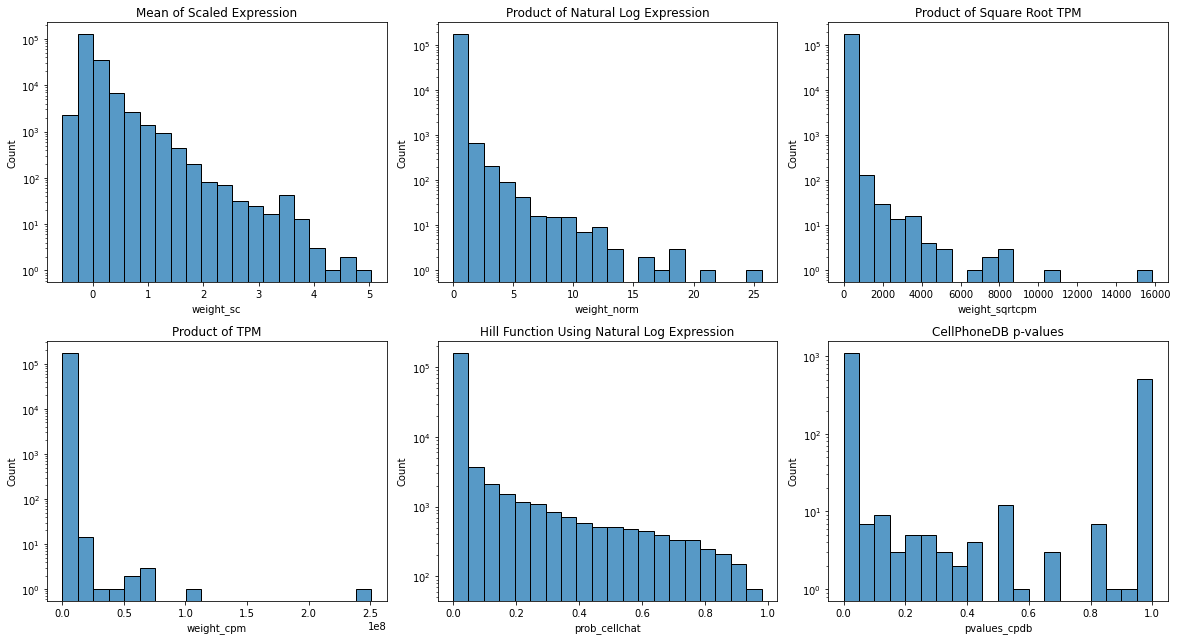

In [17]:
# filter the connectome based on a TPM threshold and minimum percentage of cells expressing the gene >0 in the cluster
mystage = "LG"

con[mystage]

# plot the heatmaps
fig, axes = plt.subplots(2,3, figsize=(5.5*3,4.5*2))

sns.histplot(data=con[mystage], x="weight_sc", log_scale=[False,True], bins=20, ax=axes.flatten()[0])
axes.flatten()[0].set_title("Mean of Scaled Expression")
sns.histplot(data=con[mystage], x="weight_norm", log_scale=[False,True], bins=20, ax=axes.flatten()[1])
axes.flatten()[1].set_title("Product of Natural Log Expression")
sns.histplot(data=con[mystage], x="weight_sqrtcpm", log_scale=[False,True], bins=20, ax=axes.flatten()[2])
axes.flatten()[2].set_title("Product of Square Root TPM")
sns.histplot(data=con[mystage], x="weight_cpm", log_scale=[False,True], bins=20, ax=axes.flatten()[3])
axes.flatten()[3].set_title("Product of TPM")
sns.histplot(data=con[mystage], x="prob_cellchat", log_scale=[False,True], bins=20, ax=axes.flatten()[4])
axes.flatten()[4].set_title("Hill Function Using Natural Log Expression")
sns.histplot(data=con[mystage], x="pvalues_cpdb", log_scale=[False,True], bins=20, ax=axes.flatten()[5])
axes.flatten()[5].set_title("CellPhoneDB p-values")

fig.tight_layout()

From this comparison, a sufficiently high cutoff of `weight_sc` or `prob_cellchat` would do the job of getting several hundred interactions, but without a clear cutoff point in the distribution.

`pvalues_cpdb`, on the other hand, has a lot of interactions with p<0.05, and a lot with p=1, and some in the middle.

It seems that the threshold method with a cutoff of 10 TPM is quite lenient, resulting in many more interactions than a CellChat probability cutoff of 0.8.

In [18]:
con["LG"]['cpm_threshold'].sum()

12251

In [19]:
(con["LG"]['prob_cellchat'] >= 0.8).sum()

594

## Quantify the number of interactions between certain cell types

Here `chinpy.ccc.filter_connectome()` is used to filter out interactions between cell clusters that don't meet certain criteria.

Here we can do that and then count the remaining interactions. Inspired by the CellPhoneDB heatmap.

The `center=15` argument of the plotting function standardizes the color scale across stages. Without it, the color would be relative within each plot.

Filtering connectome...
Pre-Filter edges: 106624
Post-Filter edges: 2477
Connectome Filtration Complete!
Filtering connectome...
Pre-Filter edges: 176256
Post-Filter edges: 5768
Connectome Filtration Complete!
Filtering connectome...
Pre-Filter edges: 78336
Post-Filter edges: 1113
Connectome Filtration Complete!
Filtering connectome...
Pre-Filter edges: 106624
Post-Filter edges: 1906
Connectome Filtration Complete!
Filtering connectome...
Pre-Filter edges: 91936
Post-Filter edges: 1893
Connectome Filtration Complete!


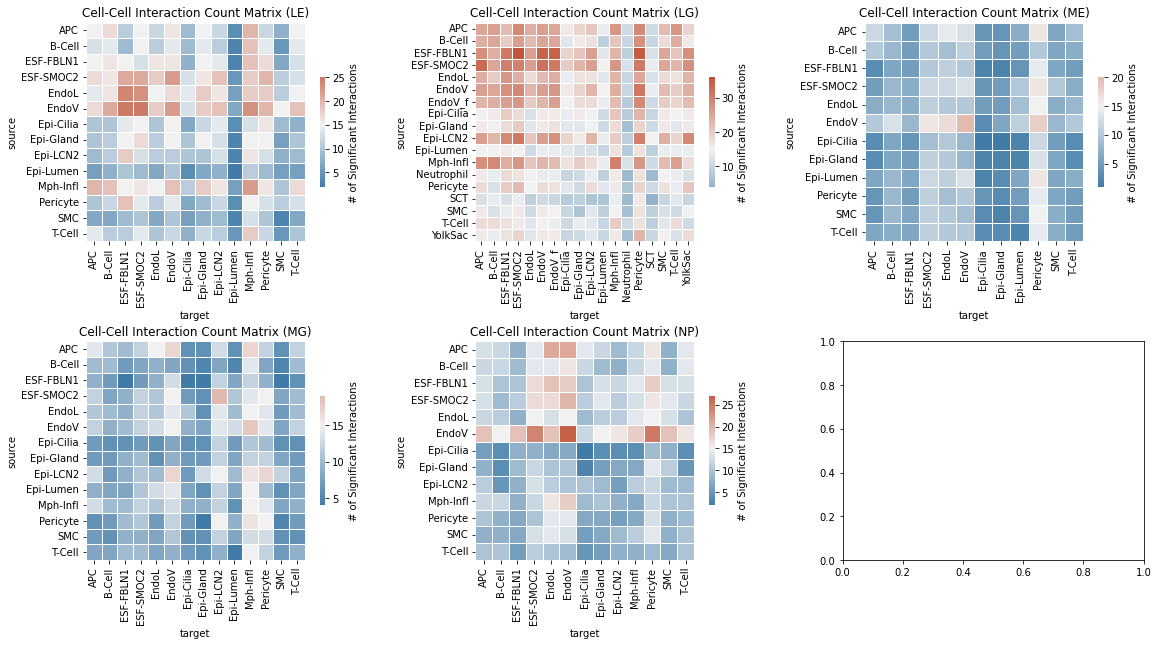

In [20]:
# filter the connectome based on a TPM threshold and minimum percentage of cells expressing the gene >0 in the cluster
con_filt = {}
for key, value in con.items():
    con_filt[key] = chinpy.ccc.filter_connectome(value, min_exp=0.25, min_cpm=10)

# plot the heatmaps
fig, axes = plt.subplots(2,3, figsize=(5.5*3,4.5*2))

for i, ax in zip(con_filt.keys(), axes.flatten()):
    df = con_filt[i].loc[:,[SOURCE,TARGET]].value_counts().unstack().fillna(0)
    sns.heatmap(df, cmap=sns.diverging_palette(240, 20, as_cmap=True), center=15,
                square=True, linewidths=.5, cbar_kws={"shrink": .5,'label': '# of Significant Interactions'}, ax=ax)
    ax.set_title("Cell-Cell Interaction Count Matrix (" + i + ")", fontsize=12)
    
fig.tight_layout()

It can also be used to explore a question, like "what are the top interactions in the VEGF pathway?"

In [25]:
chinpy.ccc.filter_connectome(con["LG"],
                             modes_include=["VEGF"],
                             min_exp=0.25, min_cpm=10,
                            ).sort_values("ligand_expression", ascending=False).head(10)

Filtering connectome...
Pre-Filter edges: 176256
Post-Filter edges: 486
Connectome Filtration Complete!


source     target ligand receptor  mode  size_source  size_target  \
142398    SCT   Epi-LCN2  VEGFA      KDR  VEGF           25          117   
146751    SCT    YolkSac  VEGFA     FLT1  VEGF           25          165   
138590    SCT  ESF-FBLN1  VEGFA      KDR  VEGF           25           61   
139135    SCT  ESF-SMOC2  VEGFA     FLT1  VEGF           25          234   
139134    SCT  ESF-SMOC2  VEGFA      KDR  VEGF           25          234   
139679    SCT      EndoL  VEGFA     FLT1  VEGF           25          326   
139678    SCT      EndoL  VEGFA      KDR  VEGF           25          326   
140223    SCT      EndoV  VEGFA     FLT1  VEGF           25          346   
140222    SCT      EndoV  VEGFA      KDR  VEGF           25          346   
140767    SCT    EndoV_f  VEGFA     FLT1  VEGF           25          239   

        percent_source  percent_target  ligand_expression  ...  \
142398            0.96        0.068376           5.664561  ...   
146751            0.96        0.387879           5.664561  ...   
138590            0.96        0.049180           5.664561  ...   
139135            0.96        0.081197           5.664561  ...   
139134            0.96        0.051282           5.664561  ...   
139679            0.96        0.107362           5.664561  ...   
139678            0.96        0.819018           5.664561  ...   
140223            0.96        0.667630           5.664561  ...   
140222            0.96        0.393064           5.664561  ...   
140767            0.96        1.000000           5.664561  ...   

        weight_sqrtcpm  weight_sc  cpm_threshold  prob_cellchat          pair  \
142398     1852.510132   2.004230           True       0.898997   VEGFA - KDR   
146751     3640.730225   2.305990           True       0.951314  VEGFA - FLT1   
138590     1076.657959   1.958951           True       0.793312   VEGFA - KDR   
139135     1941.490234   1.980067           True       0.904685  VEGFA - FLT1   
139134     1535.636353   1.963577           True       0.871572   VEGFA - KDR   
139679     1271.581421   1.972874           True       0.834872  VEGFA - FLT1   
139678     7154.013672   3.169351           True       0.970795   VEGFA - KDR   
140223     8663.316406   2.996824           True       0.973948  VEGFA - FLT1   
140222     4979.137695   2.511712           True       0.962480   VEGFA - KDR   
140767    10520.256836   3.591826           True       0.976553  VEGFA - FLT1   

                 vector  source_ligand   receptor_target  \
142398   SCT - Epi-LCN2    SCT - VEGFA    KDR - Epi-LCN2   
146751    SCT - YolkSac    SCT - VEGFA    FLT1 - YolkSac   
138590  SCT - ESF-FBLN1    SCT - VEGFA   KDR - ESF-FBLN1   
139135  SCT - ESF-SMOC2    SCT - VEGFA  FLT1 - ESF-SMOC2   
139134  SCT - ESF-SMOC2    SCT - VEGFA   KDR - ESF-SMOC2   
139679      SCT - EndoL    SCT - VEGFA      FLT1 - EndoL   
139678      SCT - EndoL    SCT - VEGFA       KDR - EndoL   
140223      SCT - EndoV    SCT - VEGFA      FLT1 - EndoV   
140222      SCT - EndoV    SCT - VEGFA       KDR - EndoV   
140767    SCT - EndoV_f    SCT - VEGFA    FLT1 - EndoV_f   

                                  edge  pvalues_cpdb  
142398    SCT - VEGFA - KDR - Epi-LCN2           NaN  
146751    SCT - VEGFA - FLT1 - YolkSac           0.0  
138590   SCT - VEGFA - KDR - ESF-FBLN1           NaN  
139135  SCT - VEGFA - FLT1 - ESF-SMOC2           NaN  
139134   SCT - VEGFA - KDR - ESF-SMOC2           NaN  
139679      SCT - VEGFA - FLT1 - EndoL           0.0  
139678       SCT - VEGFA - KDR - EndoL           0.0  
140223      SCT - VEGFA - FLT1 - EndoV           0.0  
140222       SCT - VEGFA - KDR - EndoV           0.0  
140767    SCT - VEGFA - FLT1 - EndoV_f           0.0  

[10 rows x 29 columns]

## Differential Interactions Using `chinpy.ccc.differential_connectome`

This is a re-implementation of [`Connectome::DifferentialConnectome()`](https://msraredon.github.io/Connectome/reference/DifferentialConnectome.html) in R. See [Sam's Notebook](https://msraredon.github.io/Connectome/articles/02%20Differential%20Connectomics.html) for how it works in R.

By plotting only the interactions that differ between two snapshots of the same system, it allows us to focus on only the interactions that are gained or lost.

By observation, most of the differences seem to arise from the arrival of new cell types (e.g. fetal cells in late gestation), rather than the addition of new interactions between existing cells.

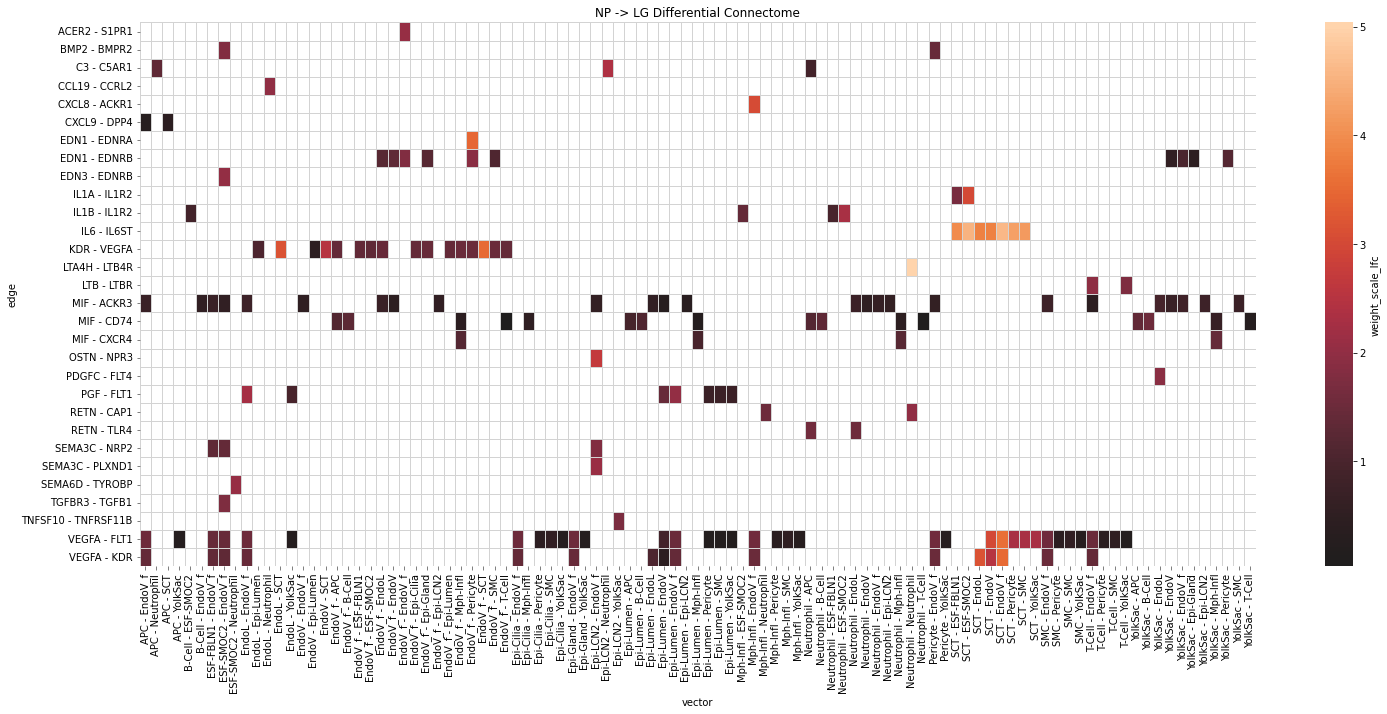

In [24]:
stage_from = "NP"
stage_to = "LG"

con_res = chinpy.ccc.differential_connectome(con[stage_from],con[stage_to],
                                             min_pct=0.2,
                                             min_score=2,
                                             exclude_unmatched=False,
                                            )

chinpy.pl.differential_connectome_heatmap(con_res, score_col="weight_scale_lfc", figsize=(25,10), min_score=0, max_score=None, center=0, title="{0} -> {1} Differential Connectome".format(stage_from, stage_to))

The reduced interactions are plotted separately.

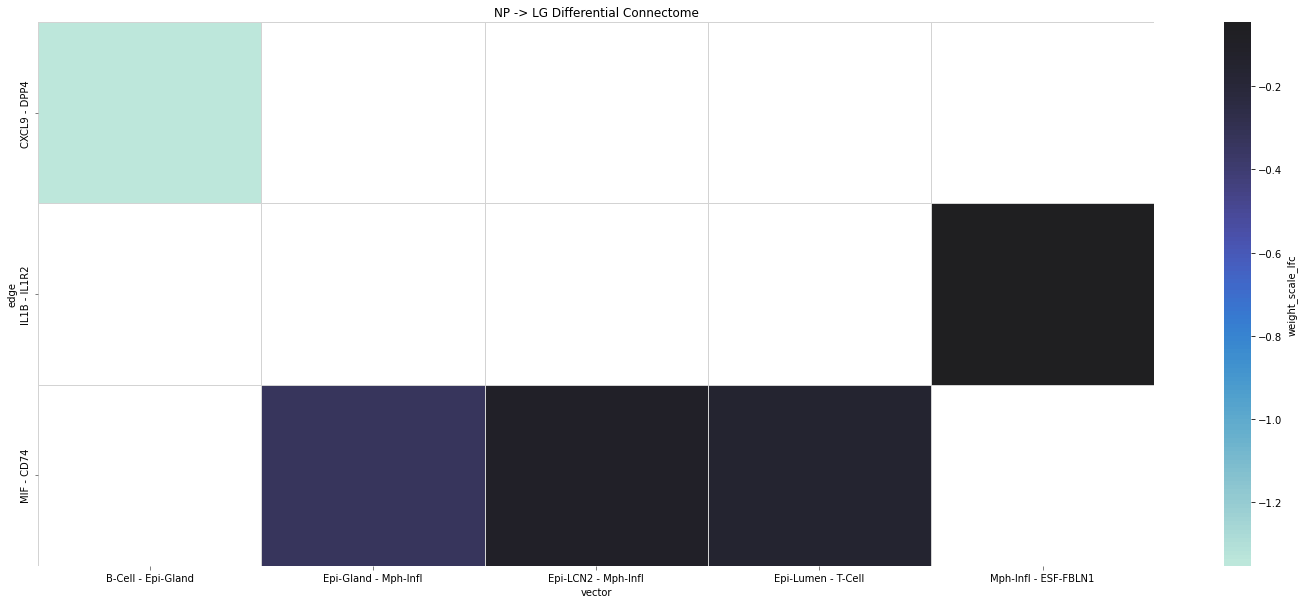

In [23]:
stage_from = "NP"
stage_to = "LG"

con_res = chinpy.ccc.differential_connectome(con[stage_from],con[stage_to],
                                             min_pct=0.2,
                                             min_score=2,
                                             exclude_unmatched=False,
                                            )

chinpy.pl.differential_connectome_heatmap(con_res, score_col="weight_scale_lfc", figsize=(25,10), min_score=None, max_score=0, center=0, title="{0} -> {1} Differential Connectome".format(stage_from, stage_to))

The differential connectome object has several new columns, such as log fold change scores for both weight statistics.

In [26]:
con_res.head(20)

mode  ligand_expression_ref  \
source    target     ligand receptor                                      
APC       EndoV_f    CXCL9  DPP4            CXCL               0.000000   
                     MIF    ACKR3            MIF               0.000000   
                     VEGFA  FLT1            VEGF               0.000000   
                            KDR             VEGF               0.000000   
          Neutrophil C3     C5AR1     COMPLEMENT               0.000000   
          SCT        CXCL9  DPP4            CXCL               0.000000   
          YolkSac    VEGFA  FLT1            VEGF               0.000000   
B-Cell    ESF-SMOC2  IL1B   IL1R2            IL1               2.796615   
          EndoV_f    MIF    ACKR3            MIF               0.000000   
          Epi-Gland  CXCL9  DPP4            CXCL               2.430033   
ESF-FBLN1 EndoV_f    MIF    ACKR3            MIF               0.000000   
                     SEMA3C NRP2           SEMA3               0.000000   
                     VEGFA  FLT1            VEGF               0.000000   
                            KDR             VEGF               0.000000   
ESF-SMOC2 EndoV_f    BMP2   BMPR2            BMP               0.000000   
                     EDN3   EDNRB            EDN               0.000000   
                     MIF    ACKR3            MIF               0.000000   
                     SEMA3C NRP2           SEMA3               0.000000   
                     TGFBR3 TGFB1          UNCAT               0.000000   
                     VEGFA  FLT1            VEGF               0.000000   

                                      recept_expression_ref  \
source    target     ligand receptor                          
APC       EndoV_f    CXCL9  DPP4                   0.000000   
                     MIF    ACKR3                  0.000000   
                     VEGFA  FLT1                   0.000000   
                            KDR                    0.000000   
          Neutrophil C3     C5AR1                  0.000000   
          SCT        CXCL9  DPP4                   0.000000   
          YolkSac    VEGFA  FLT1                   0.000000   
B-Cell    ESF-SMOC2  IL1B   IL1R2                  0.077994   
          EndoV_f    MIF    ACKR3                  0.000000   
          Epi-Gland  CXCL9  DPP4                   1.736445   
ESF-FBLN1 EndoV_f    MIF    ACKR3                  0.000000   
                     SEMA3C NRP2                   0.000000   
                     VEGFA  FLT1                   0.000000   
                            KDR                    0.000000   
ESF-SMOC2 EndoV_f    BMP2   BMPR2                  0.000000   
                     EDN3   EDNRB                  0.000000   
                     MIF    ACKR3                  0.000000   
                     SEMA3C NRP2                   0.000000   
                     TGFBR3 TGFB1                  0.000000   
                     VEGFA  FLT1                   0.000000   

                                      ligand_expression_test  \
source    target     ligand receptor                           
APC       EndoV_f    CXCL9  DPP4                    1.852901   
                     MIF    ACKR3                   2.291906   
                     VEGFA  FLT1                    1.435238   
                            KDR                     1.435238   
          Neutrophil C3     C5AR1                   2.999515   
          SCT        CXCL9  DPP4                    1.852901   
          YolkSac    VEGFA  FLT1                    1.435238   
B-Cell    ESF-SMOC2  IL1B   IL1R2                   2.235650   
          EndoV_f    MIF    ACKR3                   1.875059   
          Epi-Gland  CXCL9  DPP4                    0.280985   
ESF-FBLN1 EndoV_f    MIF    ACKR3                   2.202930   
                     SEMA3C NRP2                    1.228204   
                     VEGFA  FLT1                    0.980989   
                            KDR               

This is plotting differences between pseudo-pregnancy and pregnancy:

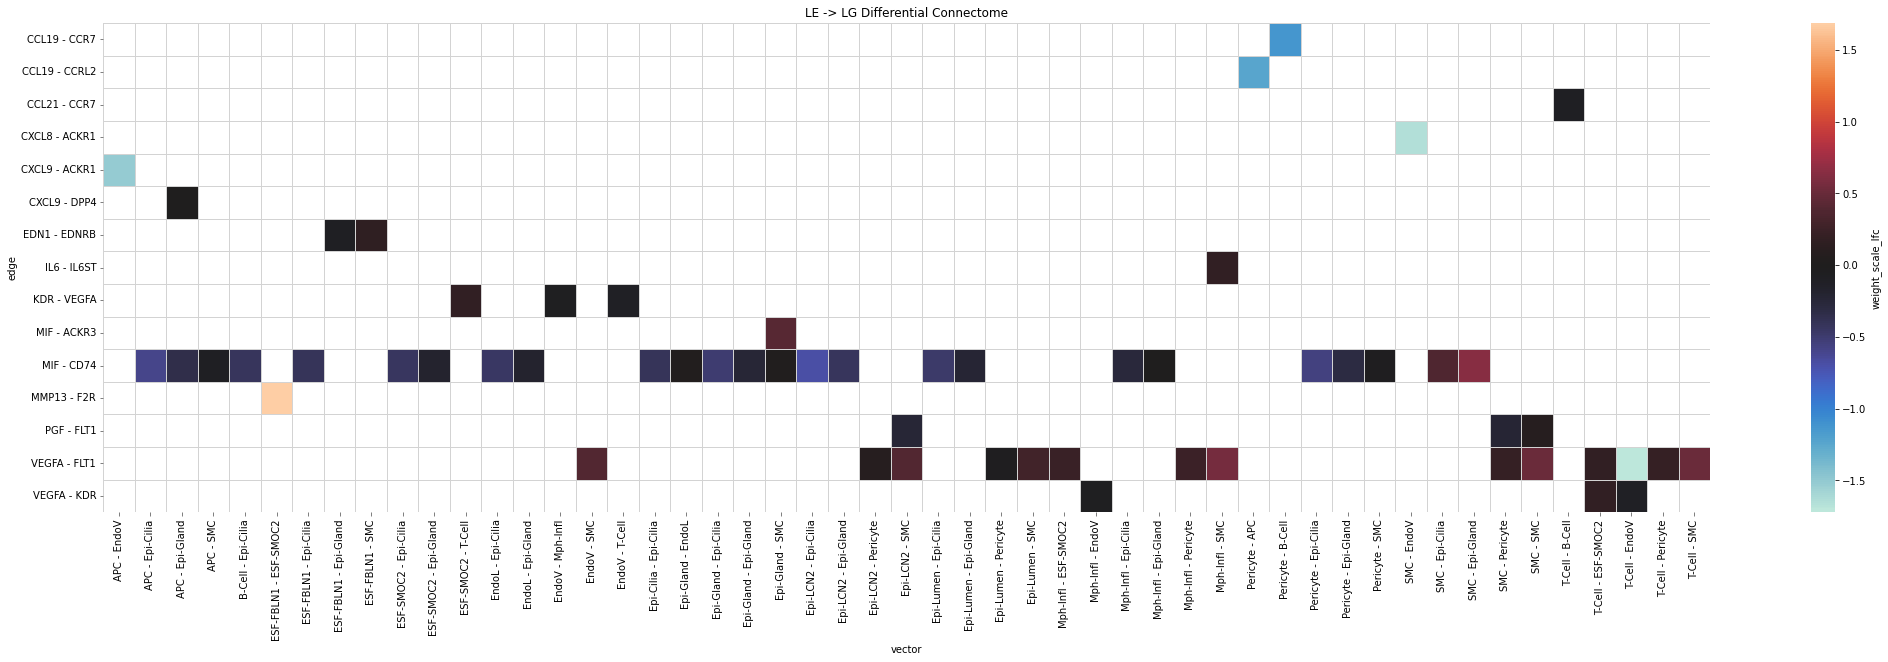

In [27]:
stage_from = "LE"
stage_to = "LG"

con_res = chinpy.ccc.differential_connectome(con[stage_from],con[stage_to],
                                             #min_pct=0.1,
                                             min_score=1, exclude_unmatched=True,
                                            )

chinpy.pl.differential_connectome_heatmap(con_res, score_col="weight_scale_lfc", figsize=(36,9), min_score=None, max_score=None, center=0, title="{0} -> {1} Differential Connectome".format(stage_from, stage_to))

## Cell-Cell Vector 2D Visualization using `chinpy.ccc.connectome_to_anndata()`

This converts a connectome into an `AnnData` object for dimensional reduction and analysis.

We can conduct dimensional reduction much like we would for normal single-cell RNA seq, for instance according to [this guide](https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_02_dim_reduction.html)

For a more complicated alternative to this using single cells rather than clusters, see [NICHES](https://msraredon.github.io/NICHES/)

In [16]:
vdata = {}

for i in con.keys():
    vdata[i] = chinpy.ccc.connectome_to_anndata(con[i])

This is like single-cell data, but the "genes" are gene-gene vectors:

In [17]:
vdata["LG"].var.head(10)

ligand receptor mode
ACER1 - S1PR1  ACER1    S1PR1  S1P
ACER1 - S1PR2  ACER1    S1PR2  S1P
ACER1 - S1PR3  ACER1    S1PR3  S1P
ACER1 - S1PR4  ACER1    S1PR4  S1P
ACER1 - S1PR5  ACER1    S1PR5  S1P
ACER2 - S1PR1  ACER2    S1PR1  S1P
ACER2 - S1PR2  ACER2    S1PR2  S1P
ACER2 - S1PR3  ACER2    S1PR3  S1P
ACER2 - S1PR4  ACER2    S1PR4  S1P
ACER2 - S1PR5  ACER2    S1PR5  S1P

The "cells" are cell-cell vectors:

In [11]:
vdata["LG"].obs.head(10)

source     target
APC - APC          APC        APC
APC - B-Cell       APC     B-Cell
APC - ESF-FBLN1    APC  ESF-FBLN1
APC - ESF-SMOC2    APC  ESF-SMOC2
APC - EndoL        APC      EndoL
APC - EndoV        APC      EndoV
APC - EndoV_f      APC    EndoV_f
APC - Epi-Cilia    APC  Epi-Cilia
APC - Epi-Gland    APC  Epi-Gland
APC - Epi-LCN2     APC   Epi-LCN2

### Annotate cells as "supertypes"

Metadata carry-over should be implemented some time into `chinpy`, but has to be done manually now.

In [31]:
# make a dictionary to map cell types to cell supertypes:
type_supertype_dict = dict(adata_parent.obs.loc[:,['leiden_coarse','leiden_supertype']].drop_duplicates().values)

In [32]:
for i in vdata.keys():
    vdata[i].obs["source_supertype"] = vdata[i].obs['source'].map(type_supertype_dict)
    vdata[i].obs["target_supertype"] = vdata[i].obs['target'].map(type_supertype_dict)

In [33]:
vdata[i].obs.head(10)

source     target source_supertype target_supertype
Epi-LCN2 - SMC         Epi-LCN2        SMC       Epithelial          Stromal
B-Cell - Epi-Cilia       B-Cell  Epi-Cilia           Immune       Epithelial
EndoV - EndoV             EndoV      EndoV      Endothelial      Endothelial
ESF-SMOC2 - B-Cell    ESF-SMOC2     B-Cell          Stromal           Immune
SMC - ESF-FBLN1             SMC  ESF-FBLN1          Stromal          Stromal
T-Cell - SMC             T-Cell        SMC           Immune          Stromal
ESF-FBLN1 - Pericyte  ESF-FBLN1   Pericyte          Stromal          Stromal
Epi-Gland - SMC       Epi-Gland        SMC       Epithelial          Stromal
Mph-Infl - EndoL       Mph-Infl      EndoL           Immune      Endothelial
B-Cell - Epi-LCN2        B-Cell   Epi-LCN2           Immune       Epithelial

### Plot PCA of Cell Type-Cell Type Vectors

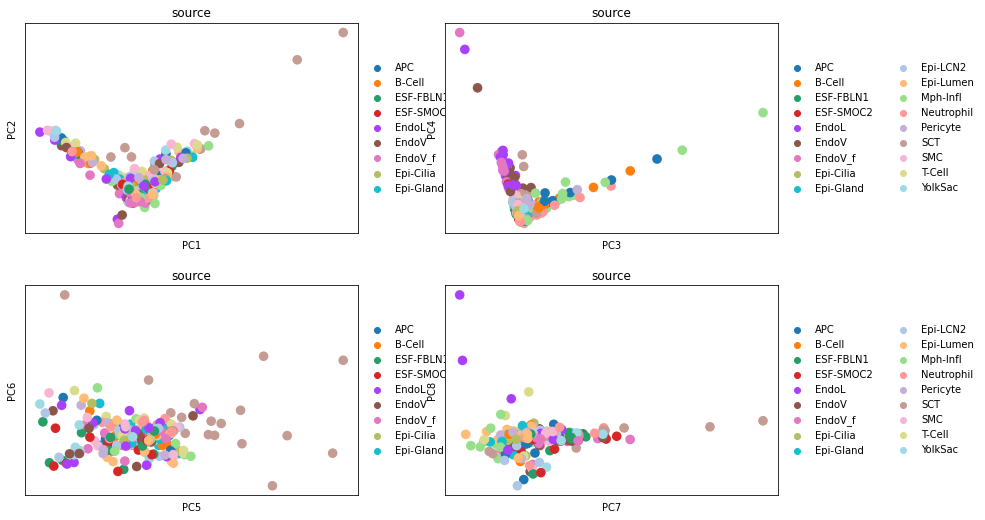

In [34]:
sc.tl.pca(vdata["LG"], svd_solver='arpack')
sc.pl.pca(vdata["LG"], color="source", components = ['1,2','3,4','5,6','7,8'], ncols=2)

We can look at the contributions to the principal components and see which gene vectors are contributing.

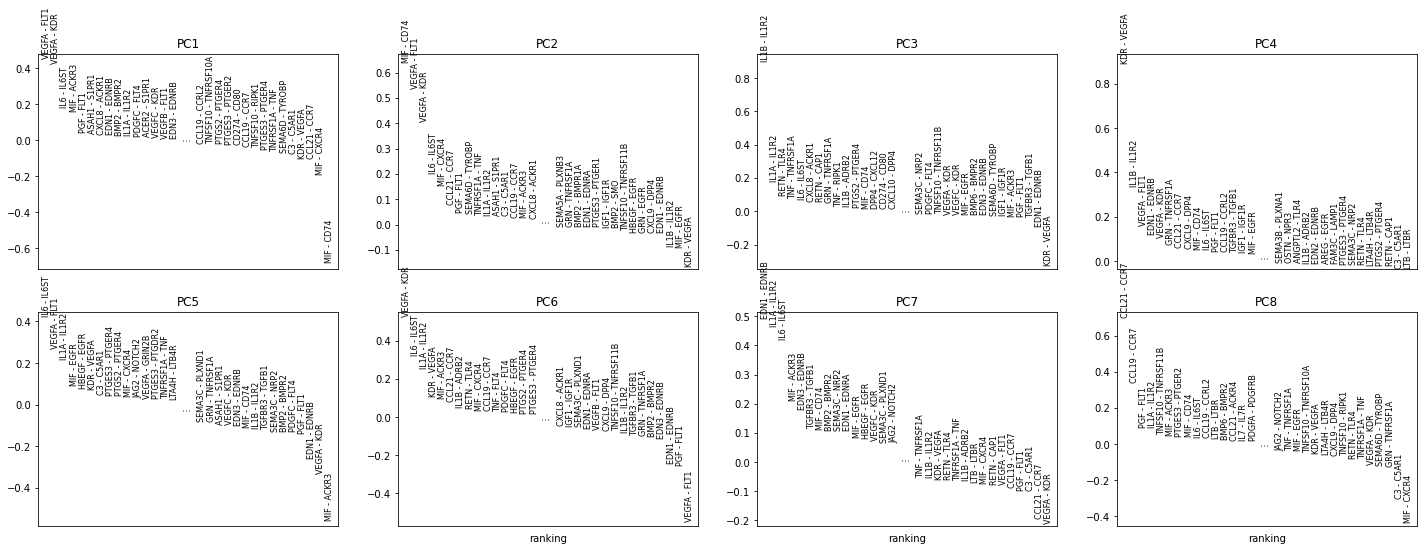

In [35]:
sc.pl.pca_loadings(vdata["LG"], components=[1,2,3,4,5,6,7,8])

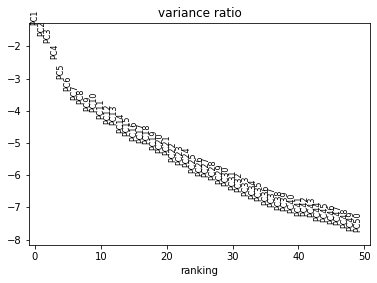

In [36]:
sc.pl.pca_variance_ratio(vdata["LG"], log=True, n_pcs = 50)

### Nonlinear dimensional reduction

Here we run UMAP and plot the embedding of cell-cell vectors, with lines corresponding to the neighborhoods.

In [37]:
sc.pp.neighbors(vdata["LG"], n_pcs = 30, n_neighbors = 5)
sc.tl.umap(vdata["LG"])

/home/djs98/project/conda/notebook_env3_clone1/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


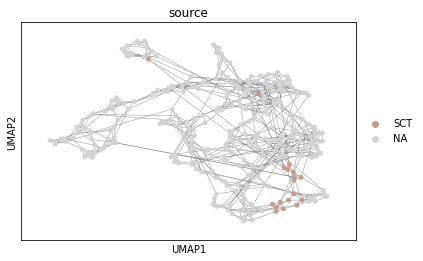

In [38]:
sc.pl.umap(vdata["LG"], color=['source'],edges=True, edges_width=0.4, s=100, groups="SCT")

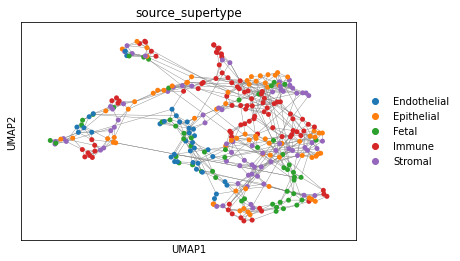

In [39]:
sc.pl.umap(vdata["LG"], color=['source_supertype'],edges=True, edges_width=0.4, s=100)
sc.pl.umap(vdata["LG"], color=['target_supertype'],edges=True, edges_width=0.4, s=100)

### Clustering of cell type-cell type vectors

In [40]:
sc.tl.leiden(vdata["LG"], resolution=0.7)
sc.pl.umap(vdata["LG"], color=['leiden'], edges=True, edges_width=0.1, s=100, legend_loc="on data")

### Differential interaction analysis

Just like differential gene expression analysis

In [41]:
sc.tl.rank_genes_groups(vdata["LG"], "leiden", method='t-test')
sc.tl.dendrogram(vdata["LG"], groupby="leiden")
sc.pl.rank_genes_groups_tracksplot(vdata["LG"], groupby='leiden', n_genes=5) # plot the result

We can also explore individual gene-gene vectors.

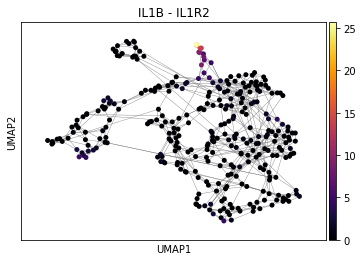

In [42]:
sc.pl.umap(vdata["LG"], color=['IL1B - IL1R2'],edges=True, edges_width=0.4, s=100, cmap="inferno")

## Graph Theory Analysis

A test of `igraph` conversion and plotting.

Filtering connectome...
Pre-Filter edges: 176256
Post-Filter edges: 294
Connectome Filtration Complete!
Converted connectome into igraph with 17 nodes and 294 edges.


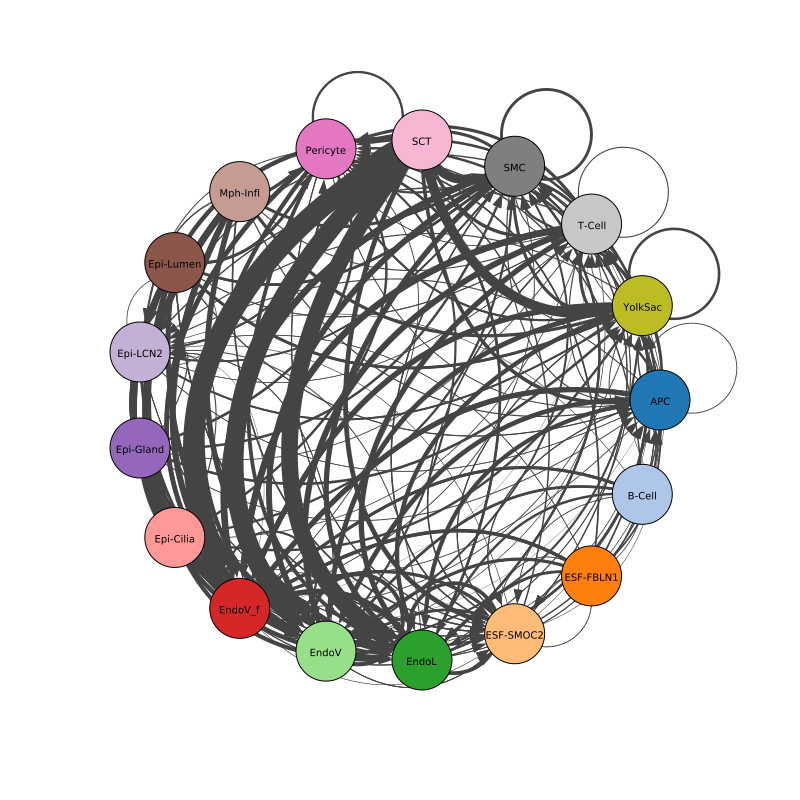

In [61]:
# make igraph
g = chinpy.ccc.connectome_to_igraph(chinpy.ccc.filter_connectome(con["LG"], min_exp=0.5, min_cpm=10,
                                                 #sources_include = supertype_type_dict["Fetal"],
                                                 #targets_include = supertype_type_dict["Epithelial"] + supertype_type_dict["Stromal"] + supertype_type_dict["Endothelial"] + supertype_type_dict["Immune"],
                                                 modes_include=["VEGF"],
                                                #features=["VEGFA"]
                                                 #mechanisms_include=[("PGF","FLT1")]
                                                ))

# plot
chinpy.ccc.igraph_plot(g, margin=140, weight_attribute = "weight_norm")

### Kleinberg hub and authority scores

These are graph theory metrics from [Kleinberg, 1999](https://dl.acm.org/doi/pdf/10.1145/345966.345982) that help to identify sources of signaling.

- Hub = lots of outgoing
- Authority = lots of incoming

For VEGF signaling, for example:

100%|██████████| 5/5 [00:00<00:00, 95.95it/s]


Filtering connectome...
Pre-Filter edges: 106624
Post-Filter edges: 73
Connectome Filtration Complete!
Filtering connectome...
Pre-Filter edges: 176256
Post-Filter edges: 152
Connectome Filtration Complete!
Filtering connectome...
Pre-Filter edges: 78336
Post-Filter edges: 46
Connectome Filtration Complete!
Filtering connectome...
Pre-Filter edges: 106624
Post-Filter edges: 56
Connectome Filtration Complete!
Filtering connectome...
Pre-Filter edges: 91936
Post-Filter edges: 73
Connectome Filtration Complete!


100%|██████████| 5/5 [00:00<00:00, 73.94it/s]


Converted connectome into igraph with 11 nodes and 73 edges.
Centrality calculations on Connectome LE complete.
Converted connectome into igraph with 16 nodes and 152 edges.
Centrality calculations on Connectome LG complete.
Converted connectome into igraph with 10 nodes and 46 edges.
Centrality calculations on Connectome ME complete.
Converted connectome into igraph with 10 nodes and 56 edges.
Centrality calculations on Connectome MG complete.
Converted connectome into igraph with 9 nodes and 73 edges.
Centrality calculations on Connectome NP complete.


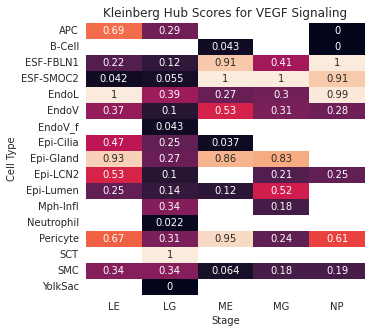

In [49]:
my_mode = "VEGF"

compcen = chinpy.ccc.compare_centrality(con, min_exp=0.1, plot=None, weight_attribute="weight_norm", min_z=0, modes_include=[my_mode])

import matplotlib.pyplot as plt
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5, 5))
    ax = sns.heatmap(pd.pivot(compcen.set_index("cells"), columns=["name"])["hub_score"],
                     annot=True, fmt='.2g',
                     cbar=False,
                    )
    ax.set_title("Kleinberg Hub Scores for {0} Signaling".format(my_mode))
    ax.set_ylabel("Cell Type")
    ax.set_xlabel("Stage")
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

This can be read column-by-column, and shows that the VEGF "hub" at late gestation (LG) is syncytiotrophoblast (SCT), while at other stages it is mainly the SMOC2+ ESF cells (ESF-SMOC2) or pericytes. This is revealing a "hand-off" of vasoregulatory signaling from the the mother to the fetus in opossum pregnancy.